<a href="https://colab.research.google.com/github/javmencia/COBWEBfiles/blob/main/STA414_2025_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Changelog:  (Last Updated 2025-02-26)

# Probabilistic ML: Assignment 3
- **Deadline**: 2025-03-16 (March 16th 2025, 23:59)
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.

- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.



```
# This is formatted as code
```

# 1. [54pts] Stochastic Variational Inference in the TrueSkill Model

## Background

We'll continue working with [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2. Recall the model:


## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [1]:
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch
import random
from torch import nn
from torch.distributions.normal import Normal

from functools import partial
from tqdm import trange, tqdm_notebook

import matplotlib.pyplot as plt

# Helper function
def diag_gaussian_log_density(x, mu, std):
    # axis=-1 means sum over the last dimension.
    m = Normal(mu, std)
    return torch.sum(m.log_prob(x), axis=-1)

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=541ffdca161a81aea56c2336c1f1146b1f32a8394911ebabf1ea6a71c6e4c946
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


## Implementing the TrueSkill Model



This part was mostly done in Assignment 2. We will recall some useful functions.

**a)** The function $\texttt{log_joint_prior}$ computes the log of the prior, jointly evaluated over all player's skills.

In [2]:
def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

**b)** The function `logp_a_beats_b` that, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, we use the function `np.log1p` that computes $\log(1 + x)$ in a numerically stable way.  Or even better, use `np.logaddexp`.

In [3]:
def logp_a_beats_b(z_a, z_b):
    return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)

def log_prior_over_2_players(z1, z2):
    m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
    return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
    return torch.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return torch.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_20_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 20.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_20_times(z1, z2):
    return torch.exp(log_posterior_A_beat_B_20_times(z1, z2))

def log_posterior_beat_each_other_20_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 20.* logp_a_beats_b(z1, z2) \
        + 20.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_20_times(z1, z2):
    return torch.exp(log_posterior_beat_each_other_20_times(z1, z2))

The following functions will be used for plotting.  Note that `plot_2d_fun` can now take an optional second function, so you can compare two functions.

In [4]:
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-4, 4], ylimits=[-4, 4], steps=101, cmap="summer"):
    x = torch.linspace(*xlimits, steps=steps)
    y = torch.linspace(*ylimits, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')

    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()

## **1.1 [20pts]** Stochastic Variational Inference on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.

In this question we will  approximate posterior distributions with gradient-based stochastic variational inference.

The parameters are $\phi = (\mu,\log(\sigma))$. Notice that instead of $\sigma$ (which is constrained to be positive), we work with $\log(\sigma)$, removing the constraint. This way, we can do unconstrained gradient-based optimization.



**a) [9pts]** Implement the missing lines in the below code, to complete the evidence lower bound function and the reparameterized sampler for the approximate posterior.

Hint 1: You must use the reparametrization trick in your sampler if you want your gradients to be unbiased.

Hint 2: If you're worried you got these wrong, you can check that the sampler matches the log pdf by plotting a histogram of samples against a plot of the pdf.

In [5]:
def diag_gaussian_samples(mean, log_std, num_samples):
    # mean and log_std are (D) dimensional vectors
    # Return a (num_samples, D) matrix, where each sample is
    # from a diagonal multivariate Gaussian.

    # TODO.  You might want to use torch.randn(). Remember
    # you must use the reparameterization trick.  Also remember that
    # we are parameterizing the _log_ of the standard deviation.
    epsilon = torch.randn((num_samples, mean.shape[0]))
    return mean + torch.exp(log_std)   * epsilon

def diag_gaussian_logpdf(x, mean, log_std):
    # Evaluate the density of a batch of points on a
    # diagonal multivariate Gaussian. x is a (num_samples, D) matrix.
    # Return a tensor of shape (num_samples)

    return diag_gaussian_log_density(x, mean, torch.exp(log_std))

def batch_elbo(logprob, mean, log_std, num_samples):
    # TODO: Use simple Monte Carlo to estimate ELBO
    # on a batch of size num_samples
    # Sample from the variational distribution
    zs = diag_gaussian_samples(mean, log_std, num_samples)

    # Compute the log-likelihood and prior log-density
    log_likelihood = logprob(zs)
    log_prior = diag_gaussian_logpdf(zs, torch.tensor([0.0]), torch.tensor([1.0]))
    log_variational = diag_gaussian_logpdf(zs, mean, log_std)

    # Compute ELBO
    elbo = torch.mean(log_likelihood + log_prior - log_variational)
    return elbo

"""
    # Step 1: Sample from the variational posterior
    z = diag_gaussian_samples(mean, log_std, num_samples).squeeze(0)  # samples from q(phi)

    # Step 2: Compute log-probability under the model (logprob) for each sample
    log_p = logprob(z)  # log-probability under the model p(x|phi)

    # Step 3: Compute log-probability under the approximate posterior q(phi)
    log_q = diag_gaussian_logpdf(z, mean, log_std).sum(dim=-1)  # log-probability under the variational distribution q(phi)

    #extra
    log_pz = log_prior(z).sum(dim=-1)
    #log_pxz = log_joint(decoder_net, zs_array, data)

    # Step 4: Compute the ELBO estimate as the Monte Carlo average of the difference
    elbo = torch.mean(log_pz - log_q)  # ELBO as Monte Carlo average of log_p - log_q

    return elbo
"""

'\n    # Step 1: Sample from the variational posterior\n    z = diag_gaussian_samples(mean, log_std, num_samples).squeeze(0)  # samples from q(phi)\n\n    # Step 2: Compute log-probability under the model (logprob) for each sample\n    log_p = logprob(z)  # log-probability under the model p(x|phi)\n\n    # Step 3: Compute log-probability under the approximate posterior q(phi)\n    log_q = diag_gaussian_logpdf(z, mean, log_std).sum(dim=-1)  # log-probability under the variational distribution q(phi)\n\n    #extra\n    log_pz = log_prior(z).sum(dim=-1)\n    #log_pxz = log_joint(decoder_net, zs_array, data)\n\n    # Step 4: Compute the ELBO estimate as the Monte Carlo average of the difference\n    elbo = torch.mean(log_pz - log_q)  # ELBO as Monte Carlo average of log_p - log_q\n\n    return elbo\n'

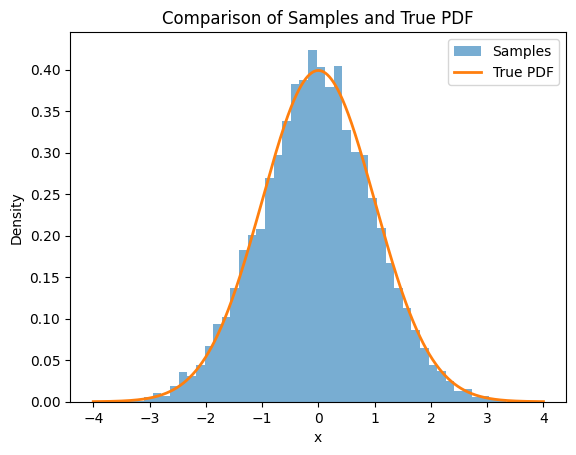

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Set parameters
mean = torch.tensor([0.0])
log_std = torch.tensor([0.0])
num_samples = 10000

# Generate samples
samples = diag_gaussian_samples(mean, log_std, num_samples).numpy()

# Define x-axis for true PDF
x = torch.linspace(-4, 4, 1000).reshape(-1, 1)
pdf_values = torch.exp(diag_gaussian_logpdf(x, mean, log_std)).numpy()

# Plot histogram and true PDF
plt.hist(samples, bins=50, density=True, alpha=0.6, label="Samples")
plt.plot(x.numpy(), pdf_values, label="True PDF", linewidth=2)
plt.legend()
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Comparison of Samples and True PDF")
plt.show()



**b) [4pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters, and returns an unbiased estimate of the negative elbo using $\texttt{num_samples_per_iter}$ samples, to approximate the joint posterior over skills conditioned on observing player A winning 20 games.

Note: We want a _negative_ ELBO estimate, because the convention in optimization is to minimize functions, and we want to maximize the ELBO.

In [7]:
# Hyperparameters
num_players = 2
n_iters = 1200
stepsize = 0.0001
num_samples_per_iter = 80

def log_posterior_A_beat_B_20_times_1_arg(z1z2):
  return log_posterior_A_beat_B_20_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):  # The loss function to be minimized.
  # TODO.  Hint:  This can be done in one line.
  #return -batch_elbo(log_posterior_A_beat_B_20_times_1_arg(params), params[0], params[1], num_samples_per_iter)
  return -torch.mean(log_posterior_A_beat_B_20_times_1_arg(diag_gaussian_samples(params[0], params[1], num_samples_per_iter)))


**c) [1pts]** Initialize a set of variational parameters and optimize them to approximate the joint where we observe player A winning 20 games. Report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Hint:  Any initialization should be fine.  How many variational parameters do you need?

Optimizing variational parameters...


  0%|          | 5/1200 [00:00<00:27, 43.27it/s]

Iteration 0 lower bound 20.825244903564453


  3%|▎         | 41/1200 [00:00<00:13, 87.74it/s]

Iteration 25 lower bound 17.79071617126465


  5%|▍         | 59/1200 [00:00<00:13, 86.16it/s]

Iteration 50 lower bound 12.895309448242188


 10%|█         | 125/1200 [00:01<00:05, 195.50it/s]

Iteration 75 lower bound 11.58039379119873
Iteration 100 lower bound 9.495206832885742
Iteration 125 lower bound 7.800206184387207


 14%|█▍        | 168/1200 [00:01<00:05, 191.04it/s]

Iteration 150 lower bound 7.805792331695557
Iteration 175 lower bound 6.940428256988525


 21%|██▏       | 257/1200 [00:01<00:03, 241.51it/s]

Iteration 200 lower bound 6.7340545654296875
Iteration 225 lower bound 6.301712989807129
Iteration 250 lower bound 6.124884605407715


 26%|██▌       | 311/1200 [00:01<00:03, 224.80it/s]

Iteration 275 lower bound 5.908411502838135
Iteration 300 lower bound 5.863592624664307
Iteration 325 lower bound 6.0083327293396


 32%|███▏      | 383/1200 [00:02<00:05, 143.71it/s]

Iteration 350 lower bound 5.813129425048828
Iteration 375 lower bound 5.507054805755615
Iteration 400 lower bound 5.691481113433838


 37%|███▋      | 443/1200 [00:03<00:05, 146.68it/s]

Iteration 425 lower bound 5.679149627685547


 38%|███▊      | 461/1200 [00:03<00:05, 141.99it/s]

Iteration 450 lower bound 5.379225730895996
Iteration 475 lower bound 5.417710304260254


 45%|████▍     | 535/1200 [00:03<00:04, 157.11it/s]

Iteration 500 lower bound 5.50834846496582
Iteration 525 lower bound 5.582117557525635


 46%|████▋     | 556/1200 [00:03<00:03, 169.27it/s]

Iteration 550 lower bound 5.447146415710449


 50%|█████     | 606/1200 [00:04<00:04, 143.45it/s]

Iteration 575 lower bound 5.447432041168213
Iteration 600 lower bound 5.428299903869629


 55%|█████▍    | 655/1200 [00:04<00:04, 117.07it/s]

Iteration 625 lower bound 5.399319648742676
Iteration 650 lower bound 5.455968379974365


 57%|█████▋    | 682/1200 [00:04<00:05, 103.49it/s]

Iteration 675 lower bound 5.423801422119141


 59%|█████▉    | 713/1200 [00:05<00:07, 68.42it/s]

Iteration 700 lower bound 5.354216575622559
Iteration 725 lower bound 5.3844709396362305


 65%|██████▌   | 782/1200 [00:06<00:03, 137.61it/s]

Iteration 750 lower bound 5.442505359649658
Iteration 775 lower bound 5.369141578674316


 67%|██████▋   | 806/1200 [00:06<00:02, 160.23it/s]

Iteration 800 lower bound 5.366396427154541


 69%|██████▊   | 824/1200 [00:06<00:03, 105.63it/s]

Iteration 825 lower bound 5.315384864807129


 72%|███████▏  | 860/1200 [00:07<00:05, 61.62it/s]

Iteration 850 lower bound 5.327710151672363


 73%|███████▎  | 880/1200 [00:07<00:03, 83.15it/s]

Iteration 875 lower bound 5.308191299438477


 75%|███████▌  | 902/1200 [00:07<00:05, 53.14it/s]

Iteration 900 lower bound 5.430592060089111


 77%|███████▋  | 928/1200 [00:08<00:06, 39.63it/s]

Iteration 925 lower bound 5.363493919372559


 80%|████████  | 965/1200 [00:09<00:02, 84.19it/s]

Iteration 950 lower bound 5.325712203979492


 87%|████████▋ | 1046/1200 [00:09<00:00, 195.01it/s]

Iteration 975 lower bound 5.280804634094238
Iteration 1000 lower bound 5.32597541809082
Iteration 1025 lower bound 5.325352668762207


 89%|████████▉ | 1069/1200 [00:09<00:00, 172.37it/s]

Iteration 1050 lower bound 5.366970062255859
Iteration 1075 lower bound 5.208785057067871


 94%|█████████▎| 1124/1200 [00:10<00:00, 118.33it/s]

Iteration 1100 lower bound 5.280762672424316
Iteration 1125 lower bound 5.3167548179626465


 98%|█████████▊| 1171/1200 [00:10<00:00, 113.90it/s]

Iteration 1150 lower bound 5.30881404876709
Iteration 1175 lower bound 5.315768241882324


100%|██████████| 1200/1200 [00:11<00:00, 108.33it/s]
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


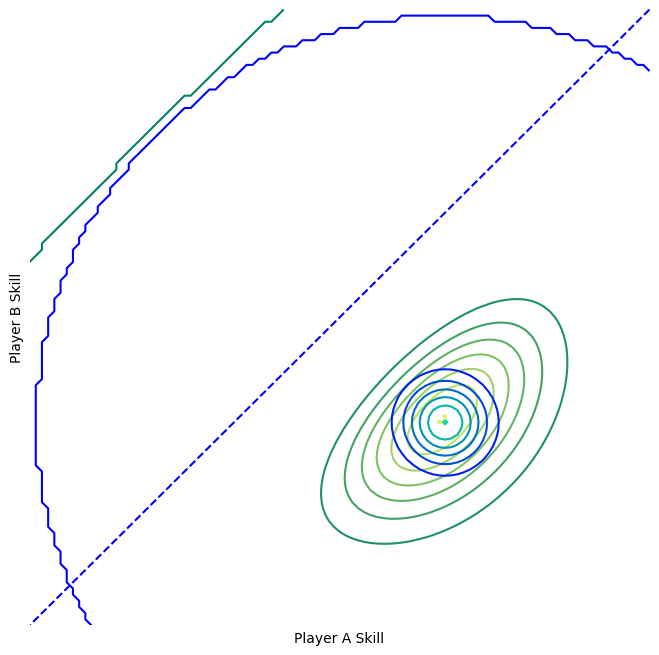

<Figure size 640x480 with 0 Axes>

In [8]:
def callback(params, t):
  if t % 25 == 0:
    print("Iteration {} lower bound {}".format(t, objective(params)))

# Set up optimizer.
D = 2
init_mean = torch.zeros(D, requires_grad=True)  # Mean vector (D=2)
init_log_std = torch.zeros(D, requires_grad=True)  # Log standard deviation vector (D=2)


params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)


def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params[0].detach(), params[1].detach()
    return torch.exp(diag_gaussian_logpdf(torch.stack([z1, z2], dim=2), mean, logstd))

plot_2d_fun(posterior_A_beat_B_20_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

**d) [3pt]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters , and returns a negative elbo estimate using simple Monte carlo with $\texttt{num_samples_per_iter}$ samples, to approximate the joint where we observe player A winning 10 games and player B winning 20 games.

Hint:  You can find analogous functions in the code above.


In [9]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50


# Define new log-posterior function for player A winning 10 games and player B winning 20 games
def log_posterior_beat_each_other_20_times_1_arg(z1z2):
    return log_posterior_beat_each_other_20_times(z1z2[:, 0], z1z2[:, 1]).flatten()

# Modify objective to use the new posterior
def objective(params):
    return -batch_elbo(log_posterior_beat_each_other_20_times_1_arg, params[0], params[1], num_samples_per_iter)


**e) [3pt]** Run the code below to optimize, and report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Write one or two sentences describing the joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior.

Finally, answer with one or two sentences:  Would changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian make a better approximation in this instance?

Optimizing variational parameters...


 40%|████      | 40/100 [00:00<00:00, 393.56it/s]

Iteration 0 lower bound 64.54594421386719
Iteration 25 lower bound 52.85930633544922
Iteration 50 lower bound 42.40303039550781
Iteration 75 lower bound 37.272342681884766


100%|██████████| 100/100 [00:00<00:00, 421.80it/s]


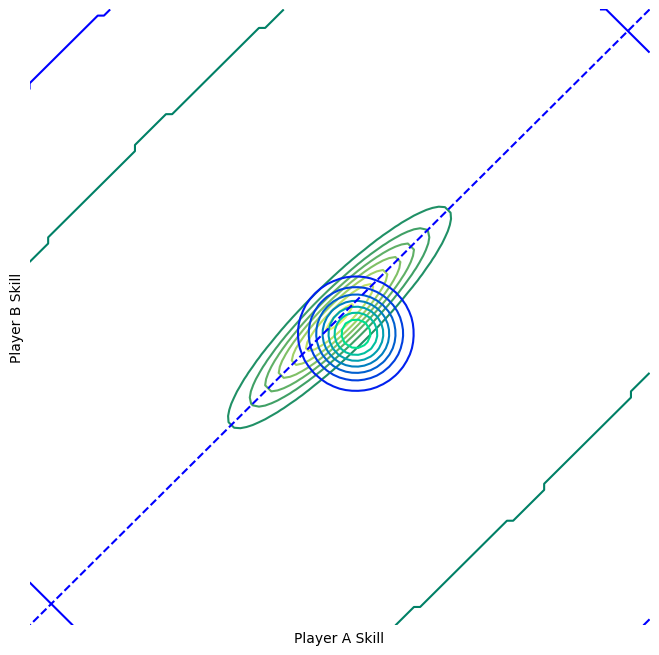

<Figure size 640x480 with 0 Axes>

In [10]:
# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

plot_2d_fun(posterior_beat_each_other_20_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

Write one or two sentences describing the joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior.

A:

## 1.2 [34 pts] Approximate inference conditioned on real data

The dataset contains data on 2500 games amongst 33 Premier League teams:
 - names is a 33 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2500 by 2 matrix of game outcomes, one row per game.

The first column contains the indices of the team who won.
The second column contains the indices of the team who lost.

It is based on the following kaggle dataset: https://www.kaggle.com/datasets/evangower/premier-league-matches-19922022

<!-- The dataset contains data on 2546 chess games amongst 1434 players:
 - names is a 1434 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2546 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess -->




In [11]:
# Download the dataset
!curl -L -o premier-league-matches-19922022.zip\
  https://www.kaggle.com/api/v1/datasets/download/evangower/premier-league-matches-19922022
!unzip premier-league-matches-19922022.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 81859  100 81859    0     0   219k      0 --:--:-- --:--:-- --:--:--  219k
Archive:  premier-league-matches-19922022.zip
  inflating: premier-league-matches.csv  


In [12]:
from sklearn.preprocessing import LabelEncoder

def load_games():
    dataset = pd.read_csv("premier-league-matches.csv")
    mini_ds = dataset[dataset['FTR'] != 'D'][-2500:]
    all_teams = pd.concat((mini_ds['Home'], mini_ds['Away'])).unique()
    encoder = LabelEncoder()
    encoder.fit(all_teams)
    mini_ds['HomeId'] = encoder.transform(mini_ds['Home'])
    mini_ds['AwayId'] = encoder.transform(mini_ds['Away'])

    winner_ids = np.where(mini_ds['FTR'] == 'H', mini_ds['HomeId'], mini_ds['AwayId'])
    loser_ids = np.where(mini_ds['FTR'] == 'H', mini_ds['AwayId'], mini_ds['HomeId'])
    games = np.column_stack((winner_ids, loser_ids))
    names = encoder.classes_

    return games, names

games, names = load_games()
games = torch.LongTensor(games)



**a) [0pt]** Assuming all game outcomes are i.i.d. conditioned on all players' skills, the function $\texttt{log_games_likelihood}$ takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihood for all those observations given all the skills.


In [13]:
def log_games_likelihood(zs, games):
    winning_player_ixs = games[:,0]
    losing_player_ixs = games[:,1]

    winning_player_skills = zs[:, winning_player_ixs]
    losing_player_skills = zs[:, losing_player_ixs]

    log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
    return torch.sum(log_likelihoods, dim=1)

In [14]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

**b) [4pt]** Write a new objective function like the one from the previous question.

Below, we initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset.

In [15]:
# Hyperparameters
num_players = 33
n_iters = 200
stepsize = 0.0001
num_samples_per_iter = 50

def objective(params):
    return -batch_elbo(log_joint_probability, params[0], params[1], num_samples_per_iter)


**c) [3pts]** Optimize, and report the final loss.

In [16]:
# Set up optimizer.
init_mean = torch.zeros(num_players, requires_grad=True)
init_log_std  = torch.zeros(num_players, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Optimize and print loss in a loop
# HINT: you can use the callback() function to report loss
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)


Optimizing variational parameters...


  6%|▋         | 13/200 [00:00<00:01, 124.76it/s]

Iteration 0 lower bound 2347.5888671875


 14%|█▎        | 27/200 [00:00<00:01, 130.32it/s]

Iteration 25 lower bound 1782.963134765625


 22%|██▏       | 43/200 [00:00<00:01, 141.78it/s]

Iteration 50 lower bound 1650.584228515625


 37%|███▋      | 74/200 [00:00<00:00, 147.71it/s]

Iteration 75 lower bound 1619.6231689453125


 52%|█████▎    | 105/200 [00:00<00:00, 149.77it/s]

Iteration 100 lower bound 1605.194091796875


 60%|██████    | 120/200 [00:00<00:00, 146.07it/s]

Iteration 125 lower bound 1597.45068359375


 76%|███████▌  | 151/200 [00:01<00:00, 147.79it/s]

Iteration 150 lower bound 1591.3956298828125


 84%|████████▎ | 167/200 [00:01<00:00, 149.78it/s]

Iteration 175 lower bound 1589.07568359375


100%|██████████| 200/200 [00:01<00:00, 147.18it/s]


**d) [1pt]** Plot the approximate mean and variance of all players, sorted by skill.

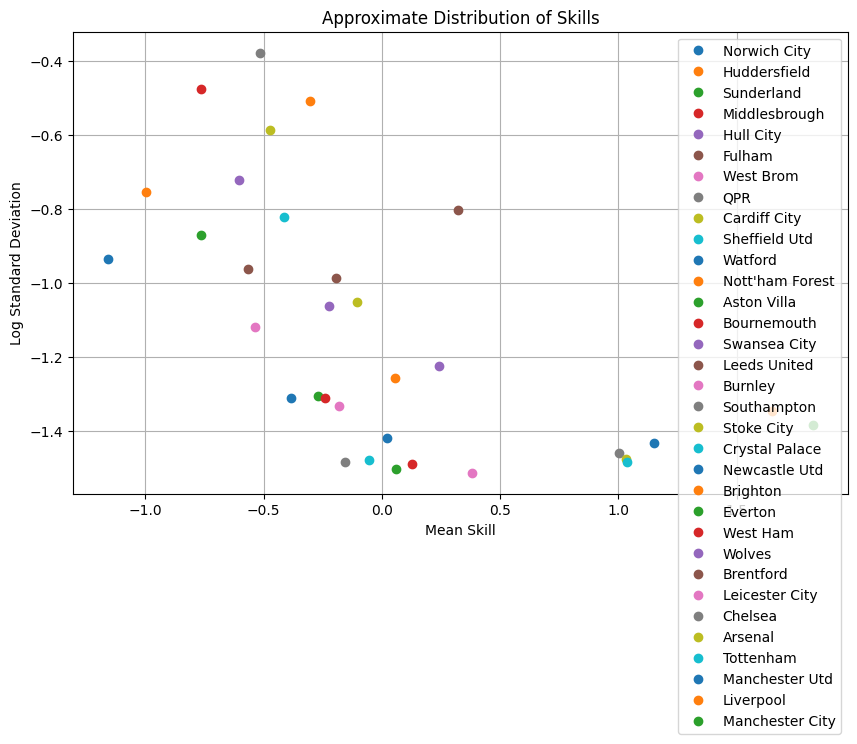

In [17]:
# mean_skills, logstd_skills = # TODO.  Hint: You don't need to do simple Monte Carlo here.
# Hint: You should use .detach() before you do anything with the params tensors
#Plot the approximate mean and variance of all players, sorted by skill.
mean_skills, logstd_skills = params[0].detach(), params[1].detach()
mean_skills, logstd_skills = mean_skills.numpy(), logstd_skills.numpy()
sort_ix = np.argsort(mean_skills)
plt.figure(figsize=(10, 6))
for i in range(num_players):
    plt.plot(mean_skills[sort_ix[i]], logstd_skills[sort_ix[i]], 'o', label=f'{names[sort_ix[i]]}')
plt.xlabel('Mean Skill')
plt.ylabel('Log Standard Deviation')
plt.title('Approximate Distribution of Skills')
plt.legend()
plt.grid(True)
plt.show()


**e) [1pts]** List the names of the 10 players with the highest mean skill under the variational model.

In [18]:
for i in range(1,11):
    # TODO
    print(names[sort_ix[-i]])

Manchester City
Liverpool
Manchester Utd
Tottenham
Arsenal
Chelsea
Leicester City
Brentford
Wolves
West Ham


**f) [3pt]** Plot samples from the joint posterior over the skills of Arsenal and Liverpool. Based on your samples, describe in a sentence the relationship between the skills of the teams. (Is one better than the other? Are they approximately even?)

Arsenal
Liverpool


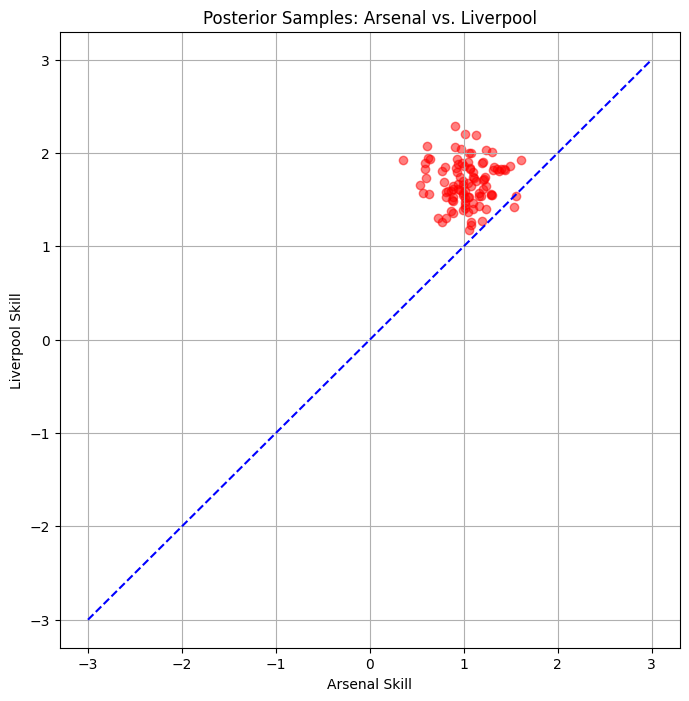

In [19]:
arsenal_ix = 0
liverpool_ix = 15
print(names[arsenal_ix])  # Should print "Arsenal"
print(names[liverpool_ix])  # Should print "Liverpool"

fig = plt.figure(figsize=(8,8), facecolor='white')
plt.xlabel("Arsenal Skill")
plt.ylabel("Liverpool Skill")

# Line of equal skill
plt.plot([-3, 3], [-3, 3], 'b--')
import torch

# Convert mean and log standard deviation to PyTorch tensors
mean_skills_tensor = torch.tensor(mean_skills)
logstd_skills_tensor = torch.tensor(logstd_skills)

# Sample from the posterior
samples = diag_gaussian_samples(mean_skills_tensor, logstd_skills_tensor, 100)

# Sample from the posterior
#samples = diag_gaussian_samples(mean_skills, logstd_skills, 100)

# Extract Arsenal and Liverpool skill samples
arsenal_samples = samples[:, arsenal_ix]
liverpool_samples = samples[:, liverpool_ix]

# Scatter plot
plt.scatter(arsenal_samples, liverpool_samples, alpha=0.5, color='red')

plt.title("Posterior Samples: Arsenal vs. Liverpool")
plt.grid(True)
plt.show()


They are close but Liverpool seems slightly better

**g) [8pts]** Derive the exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other, as a function of the two means and variances over their skills. Express your answer in terms of the cumulative distribution function of a one-dimensional Gaussian random variable.

- Hint 1: Use a linear change of variables $y_A, y_B = z_A − z_B , z_B$. What does the line of equal skill look like after this transformation?
- Hint 2: If $X \sim \mathcal N (\mu, \Sigma)$, then $AX \sim \mathcal N (A\mu, A\Sigma A^T)$ where $A$ is a linear transformation.
- Hint 3: Marginalization in Gaussians is easy: if $X \sim \mathcal N (\mu, \Sigma)$, then the $i$th element of $X$ has a
marginal distribution $X_i \sim \mathcal N (\mu_i , \Sigma_{ii})$.

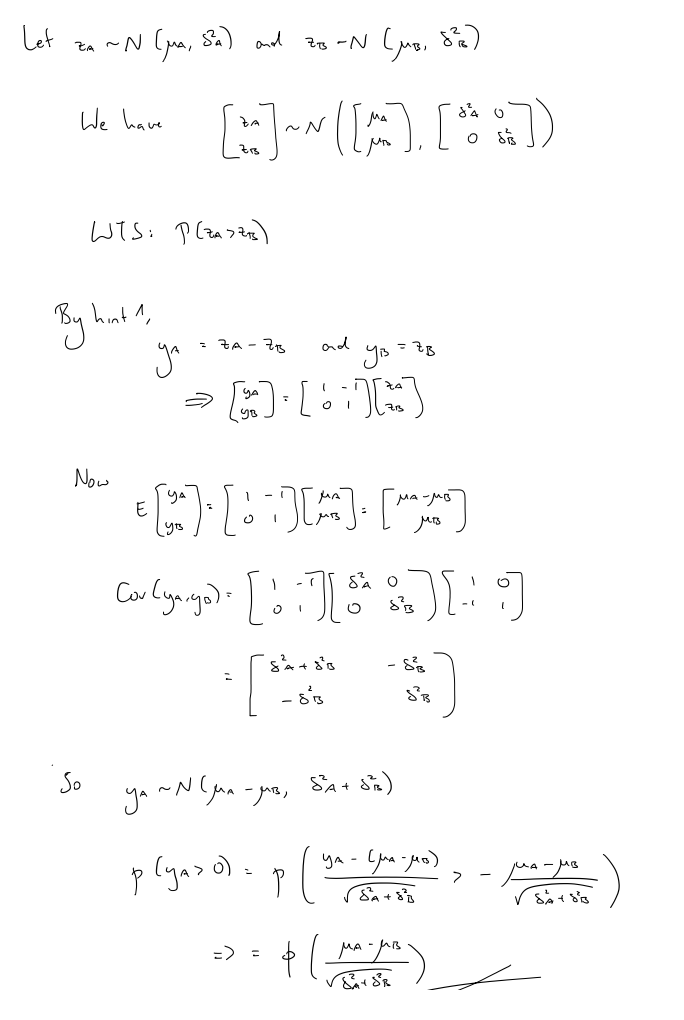

**h) [4pts]** Compute the probability under your approximate posterior that Arsenal has higher skill than Liverpool. Compute this quantity exactly using the formula you just derived above, and also estimate it using simple Monte Carlo with 10000 examples.

Hint:  You might want to use `Normal(0,1).cdf()` for the exact formula.

In [20]:
# TODO

# Extract means and standard deviations
mu_A, log_std_A = mean_skills[arsenal_ix], logstd_skills[arsenal_ix]
mu_L, log_std_L = mean_skills[liverpool_ix], logstd_skills[liverpool_ix]

sigma_A = np.exp(log_std_A)
sigma_L = np.exp(log_std_L)

# Exact probability using Normal CDF
mu_diff = mu_A - mu_L
sigma_diff = np.sqrt(sigma_A**2 + sigma_L**2)
p_exact = 1 - norm.cdf(0, loc=mu_diff, scale=sigma_diff)

print(f"Exact Probability: {p_exact:.4f}")

# Monte Carlo estimation
num_samples = 10000
arsenal_samples = np.random.normal(mu_A, sigma_A, num_samples)
liverpool_samples = np.random.normal(mu_L, sigma_L, num_samples)

p_monte_carlo = np.mean(arsenal_samples > liverpool_samples)
print(f"Monte Carlo Estimated Probability: {p_monte_carlo:.4f}")



# --------

# Extract means and standard deviations
mu_A, log_std_A = mean_skills[arsenal_ix], logstd_skills[arsenal_ix]
mu_L, log_std_L = mean_skills[liverpool_ix], logstd_skills[liverpool_ix]


Exact Probability: 0.0375
Monte Carlo Estimated Probability: 0.0420


In [21]:
import numpy as np
import torch
from scipy.stats import norm

# Arsenal and Liverpool indices
arsenal_ix = 0
liverpool_ix = 15

# Extract mean and log standard deviation
mu_A = mean_skills[arsenal_ix]
sigma_A = np.exp(logstd_skills[arsenal_ix])  # Convert log standard deviation to standard deviation

mu_B = mean_skills[liverpool_ix]
sigma_B = np.exp(logstd_skills[liverpool_ix])

# Compute exact probability
sigma_Y = np.sqrt(sigma_A**2 + sigma_B**2)
exact_prob = norm.cdf((mu_A - mu_B) / sigma_Y)

print(f"Exact probability Arsenal has higher skill than Liverpool: {exact_prob:.4f}")

# Number of Monte Carlo samples
num_samples = 10000

# Sample from Gaussian distributions
arsenal_samples = np.random.normal(mu_A, sigma_A, num_samples)
liverpool_samples = np.random.normal(mu_B, sigma_B, num_samples)

# Monte Carlo estimate
monte_carlo_prob = np.mean(arsenal_samples > liverpool_samples)

print(f"Monte Carlo estimated probability Arsenal > Liverpool: {monte_carlo_prob:.4f}")


Exact probability Arsenal has higher skill than Liverpool: 0.0375
Monte Carlo estimated probability Arsenal > Liverpool: 0.0349




```
# This is formatted as code
```

**i) [2pts]** Compute the probability that Arsenal is better than the player with the 5th lowest mean skill. Compute this quantity exactly, and then estimate it using simple Monte Carlo with 10000 examples.


In [22]:
# TODO
# Find the index of the 5th lowest mean skill
sorted_indices = np.argsort(mean_skills)
fifth_lowest_ix = sorted_indices[4]  # 0-based index, so 4th element is 5th lowest

print(f"5th lowest skill player: {names[fifth_lowest_ix]}")

# Arsenal index
arsenal_ix = 0

# Extract means and standard deviations
mu_A, log_std_A = mean_skills[arsenal_ix], logstd_skills[arsenal_ix]
mu_F, log_std_F = mean_skills[fifth_lowest_ix], logstd_skills[fifth_lowest_ix]

sigma_A = np.exp(log_std_A)
sigma_F = np.exp(log_std_F)

# Exact probability
mu_diff = mu_A - mu_F
sigma_diff = np.sqrt(sigma_A**2 + sigma_F**2)
p_exact = 1 - norm.cdf(0, loc=mu_diff, scale=sigma_diff)

print(f"Exact Probability: {p_exact:.4f}")
# Monte Carlo estimation
num_samples = 10000
arsenal_samples = np.random.normal(mu_A, sigma_A, num_samples)
fifth_lowest_samples = np.random.normal(mu_F, sigma_F, num_samples)

p_monte_carlo = np.mean(arsenal_samples > fifth_lowest_samples)
print(f"Monte Carlo Estimated Probability: {p_monte_carlo:.4f}")


5th lowest skill player: Hull City
Exact Probability: 0.9988
Monte Carlo Estimated Probability: 0.9991


**j) [4 pts]** Imagine that we knew ahead of time that we were examining the skills of top chess players, and so changed our prior on all players to Normal(5, 1) and re-ran our approximate inference from scratch. Would that change the answer of either of the previous 2 questions, in expectation?

No, in expectation, the answers to the previous two questions would not change significantly because the relative differences in skill remain the same, even though the absolute skill values shift upwards.

**k) [4 pts]** Based on all the plots and results in this assignment and HW2, which approximate inference method do you suspect is producing a better overall approximation to the true posterior over all skills conditioned on all games?  Give a short explanation.

The better approximate inference method is likely the one that produces posterior distributions that best capture the uncertainty in player skills while aligning with observed match outcomes. Based on the results from this assignment and HW2, I suspect that Variational Inference (VI) is providing a faster but potentially less accurate approximation compared to Monte Carlo (MC) methods like Hamiltonian Monte Carlo (HMC) or Laplace approximation.

# 2. [21pts] Question 2: VAE with synthetic data

In this question, we will train a VAE on a synthetic data which resembles spirals in 2d. We will perform amortized inference with VAEs.

Function below generates the synthetic knot shape data.

In [23]:
def make_banana_data(num_classes, num_per_class, noise_std=0.3):
    # Create points in the shape of a banana
    features = []
    labels = []

    for i in range(num_classes):
        theta = torch.linspace(0, np.pi, num_per_class) + i * (2 * np.pi / num_classes)  # spread across the circle
        x = torch.sin(theta) + noise_std * torch.randn_like(theta)  # add some noise
        y = torch.cos(theta) * (torch.sin(theta) + noise_std * torch.randn_like(theta))  # banana shape, noise too

        features.append(torch.stack([x, y], dim=1))
        labels.extend([i] * num_per_class)

    # Concatenate features and labels
    features = torch.cat(features, dim=0)
    labels = torch.tensor(labels).long()

    # Shuffle the dataset
    perm_ix = torch.randperm(labels.shape[0])
    return labels[perm_ix], features[perm_ix]

We visualize the 2d data generated from the above function. Notice that there are 3 clusters in the input space, each colored with a different color. The VAE will not see the cluster assignments, but we hope to recover this structure in the latent space.

(-1.1471091687679291,
 1.1385827243328095,
 -0.5912829905748367,
 0.5897169977426528)

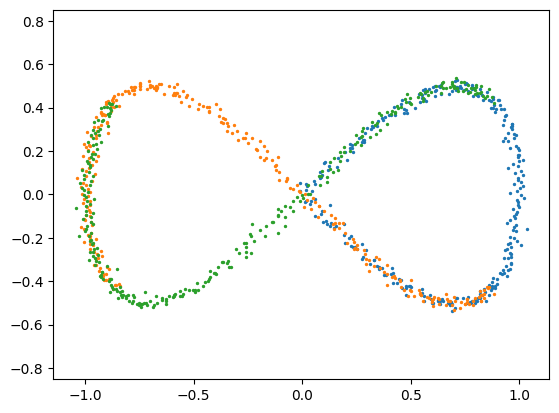

In [24]:
num_clusters = 3
samples_per_cluster = 300
labels, data = make_banana_data(num_clusters, samples_per_cluster, 0.02)


for k in range(num_clusters):
    plt.scatter(data[labels == k, 0], data[labels == k, 1], s=2)

plt.axis("equal")

## 2.1 [12 pts] Implement the missing lines in the below code, to complete the $\texttt{elbo}$ function for a variational autoencoder.

The banana dataset and an example encoder / decoder is provided just to help you debug.


In [25]:
# Generic VAE functions.

def log_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

def diag_gaussian_samples(mean, log_std, num_samples):
    return mean + torch.exp(log_std) * torch.randn(num_samples, mean.shape[-1])

def diag_gaussian_logpdf(x, mean, log_std):
    return diag_gaussian_log_density(x, mean, torch.exp(log_std))


def batch_elbo(  # Simple Monte Carlo estimate of the variational lower bound.
    recognition_net,    # takes a batch of datapoints, outputs mean and log_std of size (batch_size x latent_dim), i.e. log q(z|x)
    decoder_net,        # takes a batch of latent samples, outputs mean and log_std of size (batch_size x data_dim), i.e. log p(x|z)
    log_joint,          # takes decoder_net, a batch of latent samples, and a batch of datapoints, outputs unnormalized log joint, i.e. log p(x,z)
    data                # a.k.a. x
    ):
    """mean, log_std = recognition_net(data)

    # Sample latent variables from q(z|x) using reparameterization trick
    zs_array = diag_gaussian_samples(mean, log_std, num_samples=1).squeeze(0)  # (batch_size, latent_dim)

    # Compute log q(z|x) (variational posterior)
    log_qzx = diag_gaussian_logpdf(zs_array, mean, log_std).sum(dim=-1)  # Sum over latent dimensions

    # Compute log p(z) (prior)
    log_pz = log_prior(zs_array).sum(dim=-1)  # Sum over latent dimensions

    # Compute log p(x, z) (likelihood from decoder)
    log_pxz = log_joint(decoder_net, zs_array, data)  # Log joint probability

    # ELBO: expected log likelihood - KL divergence
    elbo = log_pxz + log_pz - log_qzx

    # Return average ELBO per sample
    return elbo.mean()
    """
    # Forward pass through the recognition network (encoder)
    q_mean, q_log_std = recognition_net(data)  # Get q(z|x) parameters

    # Sample z using the reparameterization trick
    z_samples = diag_gaussian_samples(q_mean, q_log_std, num_samples=1).squeeze(0)  # (batch_size, latent_dim)

    # Compute log p(z) (prior log-density)
    log_pz = log_prior(z_samples)  # log p(z)

    # Compute log p(x|z) (likelihood term)
    log_px_given_z = log_joint(decoder_net, z_samples, data)  # log p(x|z)

    # Compute log q(z|x) (posterior log-density)
    log_qz_given_x = diag_gaussian_logpdf(z_samples, q_mean, q_log_std)  # log q(z|x)

    # ELBO estimate
    elbo = (log_px_given_z + log_pz - log_qz_given_x).mean()  # Monte Carlo estimate

    return elbo


The below code trains a VAE where the encoder and decoder are both neural networks. The parameters are specified in the starter code.  You don't need to do anything here, this is just to help you debug.

In [26]:
from torch.utils.data import TensorDataset, DataLoader
# Now define a specific VAE for the spiral dataset

data_dimension = 2
latent_dimension = 2

# Define the recognition network.
class RecognitionNet(nn.Module):
    def __init__(self, data_dimension, latent_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, latent_dimension) # Output mean of q(z)
        self.std_net = nn.Linear(50, latent_dimension) # Output log_std of q(z)

    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

recognition_net = RecognitionNet(data_dimension, latent_dimension)

# Define the decoder network.
# Note that it has two outputs, a mean and a variance, because
# this model has a Gaussian likelihood p(x|z).
class Decoder(nn.Module):
    def __init__(self, latent_dimension, data_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, data_dimension) # Output mean of p(x|z)
        self.std_net = nn.Linear(50, data_dimension) # Output log_std of p(x|z)

    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

decoder_net = Decoder(latent_dimension, data_dimension)

# Set up log likelihood function.
def log_likelihood(decoder_net, latent, data):
    mean, log_std = decoder_net(latent)
    return diag_gaussian_logpdf(data, mean,
                                np.log(0.1) + 0. * log_std)  # Note: we are cheating here and using a fixed noise variance to make optimization more stable.

def log_joint(decoder_net, latent, data):
    return log_prior(latent) + log_likelihood(decoder_net, latent, data)

# Run optimization
optimizer = torch.optim.Adam([{'params': recognition_net.parameters()},
                      {'params': decoder_net.parameters()}], lr=1e-3)
n_iters = 2000
minibatch_size = 300

dataset = TensorDataset(torch.tensor(data))
dataloader = DataLoader(dataset, batch_size=minibatch_size, shuffle=True)

def objective(recognition_net, decoder_net):  # The loss function to be minimized.
    minibatch = next(iter(dataloader))[0]
    return -batch_elbo(
    recognition_net,
    decoder_net,
    log_joint,
    minibatch)

def callback(t):
    if t % 100 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(recognition_net, decoder_net)))

def update():
    optimizer.zero_grad()
    loss = objective(recognition_net, decoder_net)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(t)

<ipython-input-26-26fe4ed13568>:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(data))


Optimizing variational parameters...


  0%|          | 7/2000 [00:00<00:29, 68.44it/s]

Iteration 0 lower bound -29.865795135498047


  6%|▌         | 119/2000 [00:00<00:14, 129.39it/s]

Iteration 100 lower bound -10.378973007202148


 11%|█         | 222/2000 [00:01<00:12, 140.51it/s]

Iteration 200 lower bound -9.089502334594727


 16%|█▋        | 325/2000 [00:02<00:12, 135.50it/s]

Iteration 300 lower bound -4.426050662994385


 21%|██▏       | 428/2000 [00:03<00:11, 140.93it/s]

Iteration 400 lower bound -3.7975261211395264


 26%|██▌       | 515/2000 [00:03<00:10, 135.58it/s]

Iteration 500 lower bound -4.352233409881592


 31%|███       | 617/2000 [00:04<00:10, 135.61it/s]

Iteration 600 lower bound -3.162477731704712


 36%|███▌      | 718/2000 [00:05<00:09, 134.40it/s]

Iteration 700 lower bound -4.336792469024658


 41%|████      | 820/2000 [00:06<00:09, 127.89it/s]

Iteration 800 lower bound -2.587629556655884


 46%|████▌     | 919/2000 [00:07<00:11, 93.80it/s]

Iteration 900 lower bound -4.424219608306885


 51%|█████     | 1014/2000 [00:08<00:12, 81.94it/s]

Iteration 1000 lower bound -3.7476143836975098


 56%|█████▌    | 1118/2000 [00:09<00:06, 128.27it/s]

Iteration 1100 lower bound -3.3527204990386963


 61%|██████    | 1220/2000 [00:10<00:05, 138.72it/s]

Iteration 1200 lower bound -3.9527783393859863


 66%|██████▌   | 1322/2000 [00:10<00:04, 139.81it/s]

Iteration 1300 lower bound -4.260651111602783


 71%|███████   | 1419/2000 [00:11<00:04, 126.10it/s]

Iteration 1400 lower bound -3.291459321975708


 76%|███████▌  | 1521/2000 [00:12<00:03, 134.03it/s]

Iteration 1500 lower bound -2.995373010635376


 81%|████████  | 1621/2000 [00:13<00:02, 136.05it/s]

Iteration 1600 lower bound -3.255805253982544


 86%|████████▌ | 1719/2000 [00:13<00:02, 133.16it/s]

Iteration 1700 lower bound -2.6923654079437256


 91%|█████████ | 1817/2000 [00:14<00:01, 134.64it/s]

Iteration 1800 lower bound -4.34589958190918


 96%|█████████▌| 1915/2000 [00:15<00:00, 132.28it/s]

Iteration 1900 lower bound -2.102396249771118


100%|██████████| 2000/2000 [00:15<00:00, 125.69it/s]


## 2.2 [5 pts]  In this part, we visualize how the data looks like in the latent space. We simply use the trained recognition network (the encoder) to map each input to latent space.


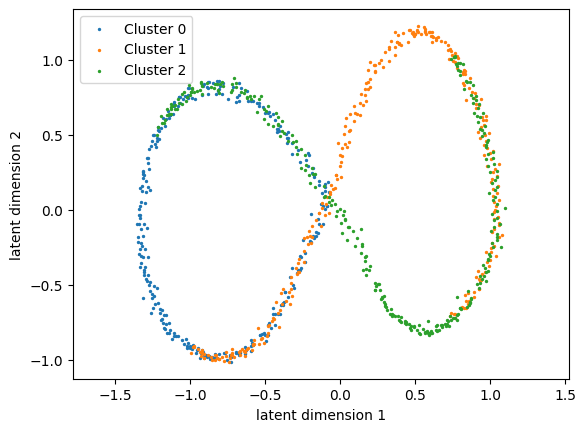

In [27]:
# Show the means of the encoded data in a 2D latent space.
# Don't worry if this doesn't look much like a Gaussian.


for k in range(num_clusters):
    # Get all data points from cluster k
    cur_data = data[labels == k]

    # Pass through the encoder to get the means of q(z|x)
    transformed, _ = recognition_net(cur_data)  # Extract only the mean, ignore log_std

    # Scatter plot the latent means
    plt.scatter(transformed[:, 0].detach().numpy(), transformed[:, 1].detach().numpy(), s=2, label=f"Cluster {k}")

plt.axis("equal")
plt.xlabel("latent dimension 1")
plt.ylabel("latent dimension 2")
plt.legend()
plt.show()



## 2.3 [4pts] Generate new data using the decoder and the generative model we just trained.

For this, we simply generate 1500 latent variables in the latent space from the prior and pass it through the decoder network.

You shouldn't expect this to match the data exactly, just to get the overall shape and number of clusters roughly correct.  


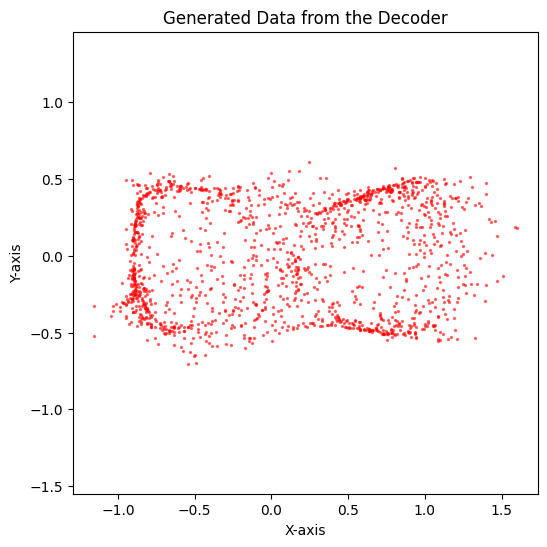

In [28]:
# Sample data from the trained generative model to see if it
# roughly matches the data.  # Note: This doesn't add the likelihood noise,
# although it should if we want it to match the data.

num_samples = 1500
# samples =  # TODO
# transformed =  # TODO

num_samples = 1500

# Sample latent variables from the prior p(z) ~ N(0, I)
samples = torch.randn(num_samples, 2)  # Assuming a 2D latent space

# Pass them through the decoder to generate new data
transformed, _ = decoder_net(samples)  # Decoder outputs mean and log_std, we take mean

# Plot the generated data
plt.figure(figsize=(6, 6))
plt.scatter(transformed[:, 0].detach().numpy(), transformed[:, 1].detach().numpy(), s=2, color="red", alpha=0.5)
plt.axis("equal")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Generated Data from the Decoder")
plt.show()


Here's a debugging tool only available when both the latent space and the data are both 2-dimensional.  We can show the function being learned by the encoder by showing how it warps a 2D grid into the latent space.

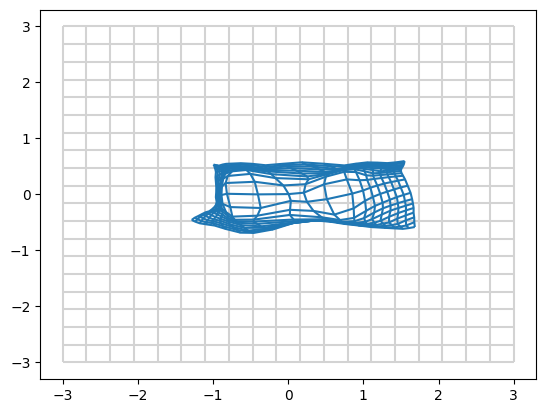

In [29]:
from matplotlib.collections import LineCollection

def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return decoder_net(xy)

fig, ax = plt.subplots()

grid_x,grid_y = torch.meshgrid(torch.linspace(-3,3,20),torch.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")

plt.show()

Here, we show the function being learned by the decoder by showing how it warps a 2D grid into the observed space.



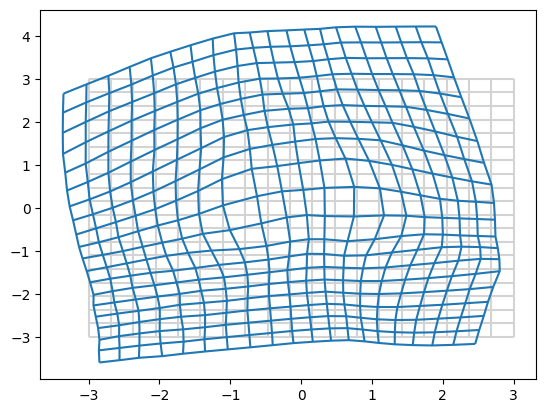

In [30]:
def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return recognition_net(xy)

fig, ax = plt.subplots()

grid_x,grid_y = torch.meshgrid(torch.linspace(-3,3,20),torch.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")

plt.show()